peso conhecido: 1678g
medições com o sensor invertido: 819 591 931 642 517
medições com o sensor corrigido: -1952 -896 -452 -426 -425 -551 -447 -531 -540 -856 -592 -600 -460 -424 -45 -448
novo: [485, 469, 568, 464, 487]

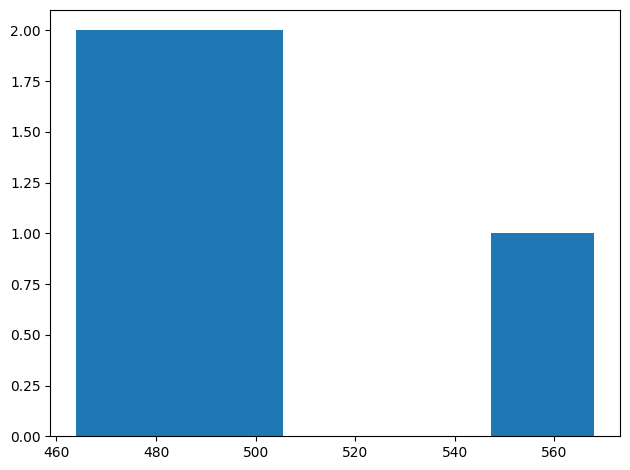

494.6


In [10]:
import matplotlib.pyplot as plt
import numpy as np

dist1 = [485, 469, 568, 464, 487]

fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

plt.hist(dist1, bins=5)

plt.show()

print(np.mean(dist1))

In [4]:
# calibration factor = (reading)/(known weight)

calibration_factor = (-312881 -311888 -311336 -311229 -310951)/(5*(148.9+177+196.3+201.1))
calibration_factor

-430.8820682980782

In [5]:
148.9+177+196.3+201.1

723.3000000000001

# Calibração de FSR

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

# Gerando dados fake

## Replicando curva do artigo base

/tmp/ipykernel_9618/980988616.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


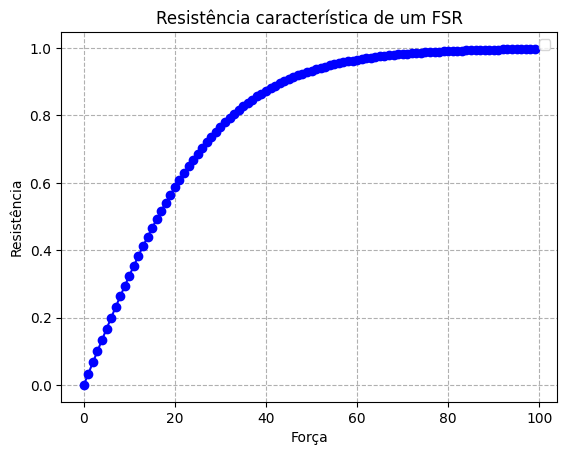

In [20]:
# Plot the log-shaped list
plt.plot(np.tanh(np.linspace(start=0, stop=10, num=100)/3), marker='o', linestyle='-', color='b')


# Customize the plot
plt.title('Resistência característica de um FSR')
plt.xlabel('Força')
plt.ylabel('Resistência')
#plt.yscale('log')  # Set y-axis to log scale
#plt.xscale('log') 
plt.grid(True, which="both", ls="--")  # Add a grid
plt.legend()

# Display the plot
plt.show()

/tmp/ipykernel_9618/4049714212.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


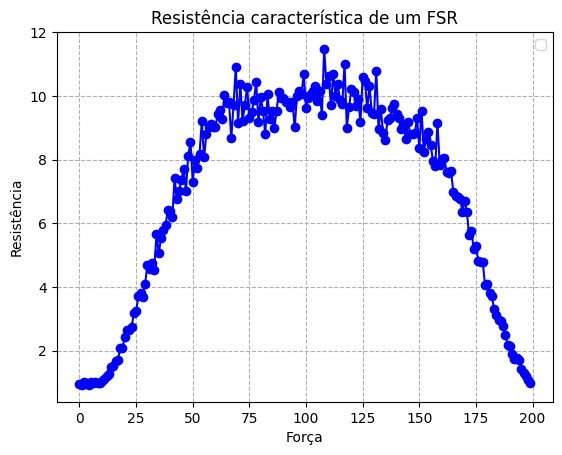

In [32]:
## versão mais proxima da realidade

# Define parameters
start = 0      # Starting exponent (log10 scale)
stop = 10       # Stopping exponent (log10 scale)
num_values = 90    # Number of values in the list
histeresis = 10

# Generate log-shaped list of floats
#log_data = np.logspace(start=start_exp, stop=stop_exp, num=num_values)
hip_data = np.tanh(np.linspace(start=start, stop=stop, num=num_values)/3)
# Control noise level
noise_level = 0.02  # Standard deviation of the noise

# Generate homogeneous noise (Gaussian noise with mean=0 and std=noise_level)
noise_1 = np.random.normal(loc=0, scale=noise_level, size=num_values+histeresis)
noise_2 = np.random.normal(loc=0, scale=noise_level, size=num_values+histeresis)

# Add noise to the log data

data_1 = np.concatenate((np.linspace(np.tanh(start), np.tanh(start), num=histeresis), hip_data)) + noise_1
data_2 = np.concatenate((hip_data, np.linspace(np.tanh(stop), np.tanh(stop), num=histeresis))) + noise_2

simulated_data_Delta = np.concatenate((data_1, data_2[::-1]))
simulated_data_Delta = 10**simulated_data_Delta

for i in range(len(simulated_data_Delta)):
    if (simulated_data_Delta[i] < 0):
        simulated_data_Delta[i] = 0


# Plot the log-shaped list
plt.plot(simulated_data_Delta, marker='o', linestyle='-', color='b')

# Customize the plot
plt.title('Resistência característica de um FSR')
plt.xlabel('Força')
plt.ylabel('Resistência')
#plt.yscale('log')  # Set y-axis to log scale
#plt.xscale('log') 
plt.grid(True, which="both", ls="--")  # Add a grid
plt.legend()

# Display the plot
plt.show()

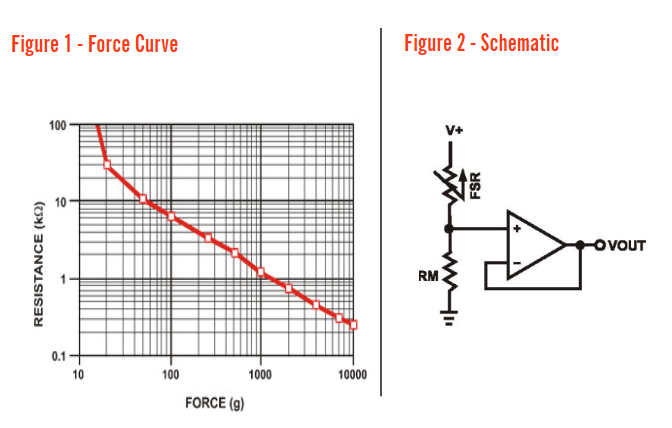

/tmp/ipykernel_9618/3622844604.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


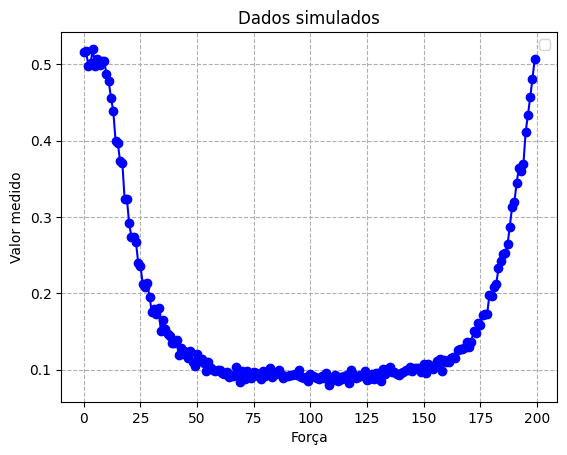

In [33]:
data = 1/(1 + simulated_data_Delta)
indexes = np.array(range(len(data)))

plt.plot(indexes, data, marker='o', linestyle='-', color='b')


# Customize the plot
plt.title('Dados simulados')
plt.xlabel('Força')
plt.ylabel('Valor medido')
#plt.yscale('log')  # Set y-axis to log scale
plt.grid(True, which="both", ls="--")  # Add a grid
plt.legend()

# Display the plot
plt.show()

In [34]:
# salvando dados


raw_data = []
for i in range(len(data)):
    raw_data.append([data[i], indexes[i]])

df = pd.DataFrame(raw_data, index=range(len(data)),columns=["FSR", "LoadCell"])
df.to_csv("simulated_data_01")

Dados simulados sob hipótese de homocedasticidade e sem drift

Será gerada uma curva de cada tipo, junto do perfil de carga correspondente.

### Vários spikes

### Senoide

### Senoide 

# Tratando dados coletados

In [6]:
file = open("coleta de dados 02 (manual)", "r")
content = file.readlines()
file.close()
content = content[0:-1]


raw_data = []
for i in range(len(content)):
    
    temp = content[i].strip("\n").split(" - ")
    raw_data.append([float(j.strip(" ")) for j in temp])

df = pd.DataFrame(raw_data, index=range(len(content)),columns=["FSR", "LoadCell"])
df.to_csv("raw_data_02_manual")

# Métodos dinâmicos

## Réplica do estado da arte e discussão

Supondo que a célula de carga tem comportamento linear, podemos fazer regressões com:

In [7]:
## definindo funções de tratamento de dados e regressao plinomial

def moving_average(arr, window_size):
    weights = np.ones(window_size) / window_size  # Create weights for averaging
    return np.convolve(arr, weights, mode='same')  # Use 'valid' to avoid edge effects

def generate_sample_data(data, window_size, seed = 42):

    # Generate sample data
    np.random.seed(seed)
    X1 = data
    moving_integral = moving_average(X1, window_size)
    X2 = moving_integral
    y = np.concatenate((np.array(range(int(len(X1)/2))), np.array(range(int(len(X1)/2)))[::-1]))  # Target variable with noise

    # Combine features into a single 2D array
    X = np.column_stack((X1, X2))

    return X, y
    
def polynomial_features(X, degree):
    
    n_samples, n_features = X.shape
    # Create a list to store the polynomial features
    features = []

    # Generate polynomial features
    for d in range(1, degree + 1):
        for i in range(n_features):
            for j in range(i, n_features):
                features.append((X[:, i] ** d) * (X[:, j] ** (d - i)))
                
    return np.column_stack(features)


    return X_poly



In [8]:
forecasts = pd.DataFrame(columns=np.arange(len(data)), index=np.arange(5)+1)
features = pd.DataFrame(columns=np.arange(16), index=np.arange(5)+1)

window_size = 10


for degree in np.arange(5)+1:
    
    X, y = generate_sample_data(data, window_size, seed = 42)
    
    # Create polynomial features of degree 
    X_poly = polynomial_features(X, degree=degree)
    # Add a bias (intercept) term
    X_poly_biased = np.c_[np.ones(X_poly.shape[0]), X_poly]  # Add a column of ones for the bias term

    # Calculate the coefficients using the normal equation
    theta = np.linalg.inv(X_poly_biased.T @ X_poly_biased) @ X_poly_biased.T @ y

    # Making predictions
    predictions = X_poly_biased @ theta

    forecasts.loc[degree] = predictions
    features.loc[degree] = np.concatenate((theta, np.zeros(16-len(theta))))
    

NameError: name 'data' is not defined

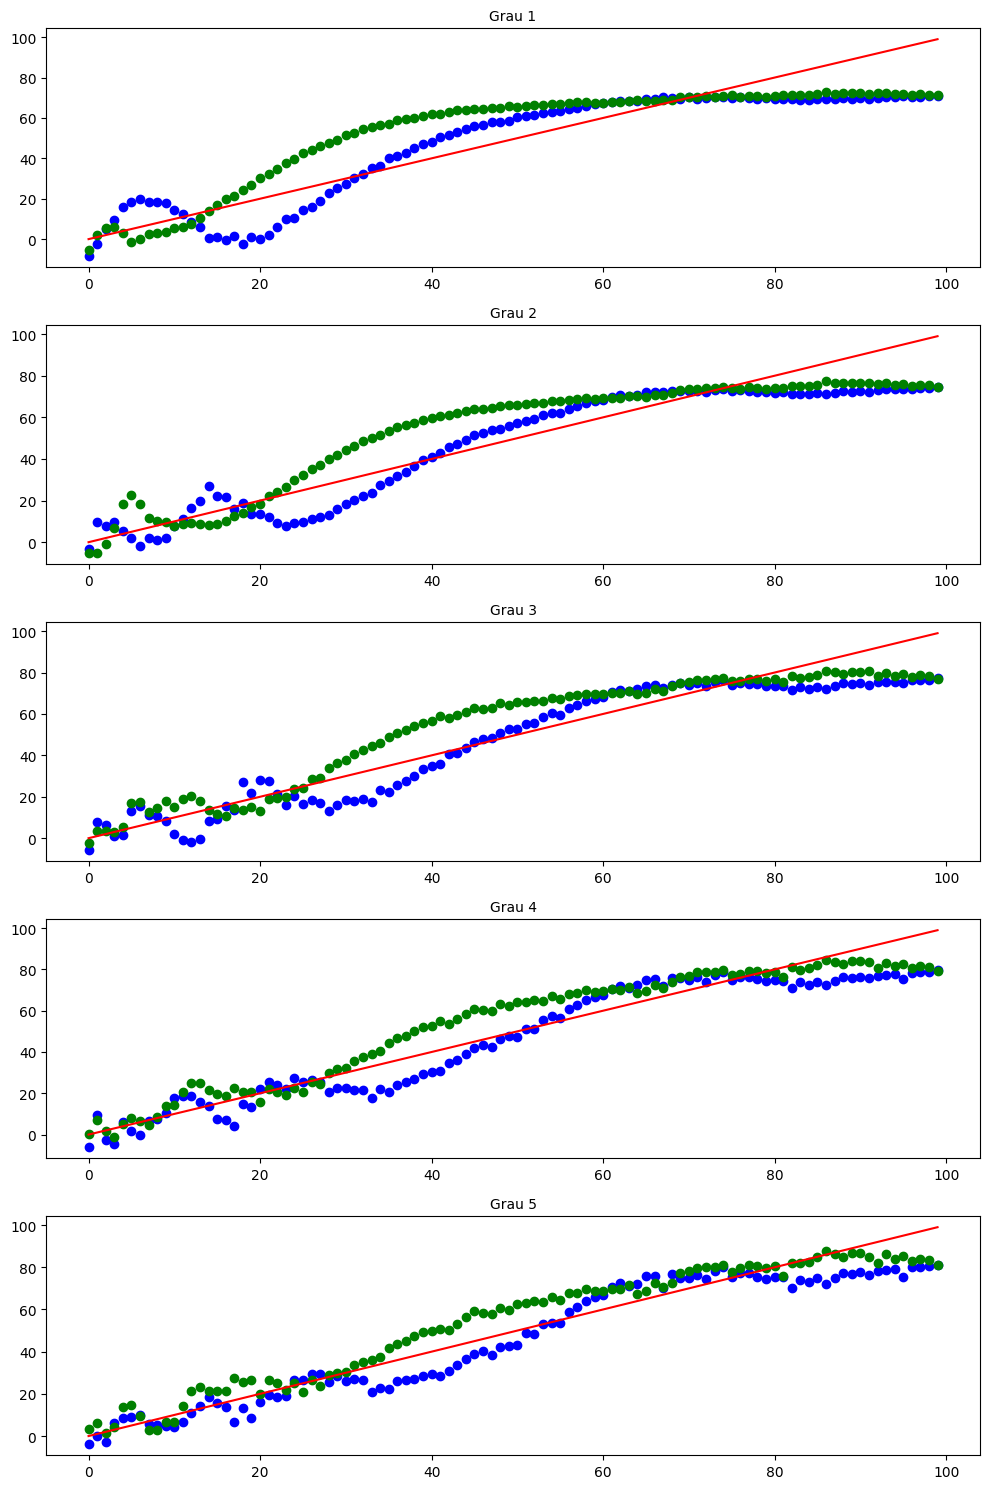

In [37]:
# Plotting the results

# Create subplots (2 rows, 3 columns)
fig, axs = plt.subplots(5, 1, figsize=(10, 15))


for i in forecasts.index:
        
    axs[i-1].scatter(y[:int(len(y)/2)], forecasts.loc[i][:int(forecasts.loc[i].count()/2)], color = 'blue')
    axs[i-1].scatter(y[int(len(y)/2):], forecasts.loc[i][int(forecasts.loc[i].count()/2):], color = 'green')
    axs[i-1].plot([min(y), max(y)], [min(y), max(y)], color='red')  # Line for perfect prediction
    axs[i-1].set_title('Grau ' + str(i), fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


O dado simulado sugere que grau 4 é um valor um tanto arbitrário. Para avaliar isso, é necessário testar não usar a média móvel e testar a generalização do modelo

## Modelo de grau 4 sem média móvel

In [27]:
X, y = generate_sample_data(data, window_size = 10, seed = 42)
X = data
degree = 4

# Create polynomial features of degree 
X_poly_biased = np.column_stack([X**i for i in range(degree + 1)])

# Calculate the coefficients using the normal equation
theta = np.linalg.inv(X_poly_biased.T @ X_poly_biased) @ X_poly_biased.T @ y
# Making predictions
predictions = X_poly_biased @ theta

# Step 6: Plot the results
plt.figure(figsize=(10, 6))

plt.scatter(y[:int(len(y)/2)], predictions[:int(len(predictions)/2)], color = 'blue')
plt.scatter(y[int(len(y)/2):], predictions[int(len(predictions)/2):], color = 'green')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  # Line for perfect prediction
plt.title('Grau ' + str(i), fontsize=10)

    
# Add labels and title
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Polynomial Regression and Forecasting')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'data' is not defined

O modelo fica terrível sem a média móvel, então essa parte não pode ser deixada de lado.

## Tentando com outras médias móveis (grau 4)

In [8]:
forecasts = pd.DataFrame(columns=np.arange(len(data)), index=np.arange(5, 20, 5))
features = pd.DataFrame(columns=np.arange(16), index=np.arange(5, 20, 5))

degree = 4


for window_size in forecasts.index:
    
    X, y = generate_sample_data(data, window_size, seed = 42)
    
    # Create polynomial features of degree 
    X_poly = polynomial_features(X, degree=degree)
    
    # Add a bias (intercept) term
    X_poly_biased = np.c_[np.ones(X_poly.shape[0]), X_poly]  # Add a column of ones for the bias term

    # Calculate the coefficients using the normal equation
    theta = np.linalg.inv(X_poly_biased.T @ X_poly_biased) @ X_poly_biased.T @ y

    # Making predictions
    predictions = X_poly_biased @ theta

    forecasts.loc[window_size] = predictions
    features.loc[window_size] = np.concatenate((theta, np.zeros(16-len(theta))))
    

In [9]:
forecasts

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
5,5.293401,6.400595,7.431906,7.427673,7.490901,7.538412,7.53826,7.611716,7.753023,7.82166,...,12.431236,11.889426,11.183741,10.485636,9.957981,9.275213,8.785877,8.379203,7.02289,5.676149
10,5.508285,5.964247,6.441246,6.944436,7.408056,7.900482,7.971978,8.021298,8.100647,8.17757,...,13.156343,12.32849,11.674491,11.007438,10.50516,9.981322,9.072556,8.210833,7.404099,6.615605
15,5.039329,5.388504,5.734244,6.132627,6.492802,6.868257,7.282042,7.747751,7.877365,8.091404,...,12.839146,12.066097,11.431004,10.436092,9.527763,8.692218,7.974359,7.241634,6.579427,5.957604


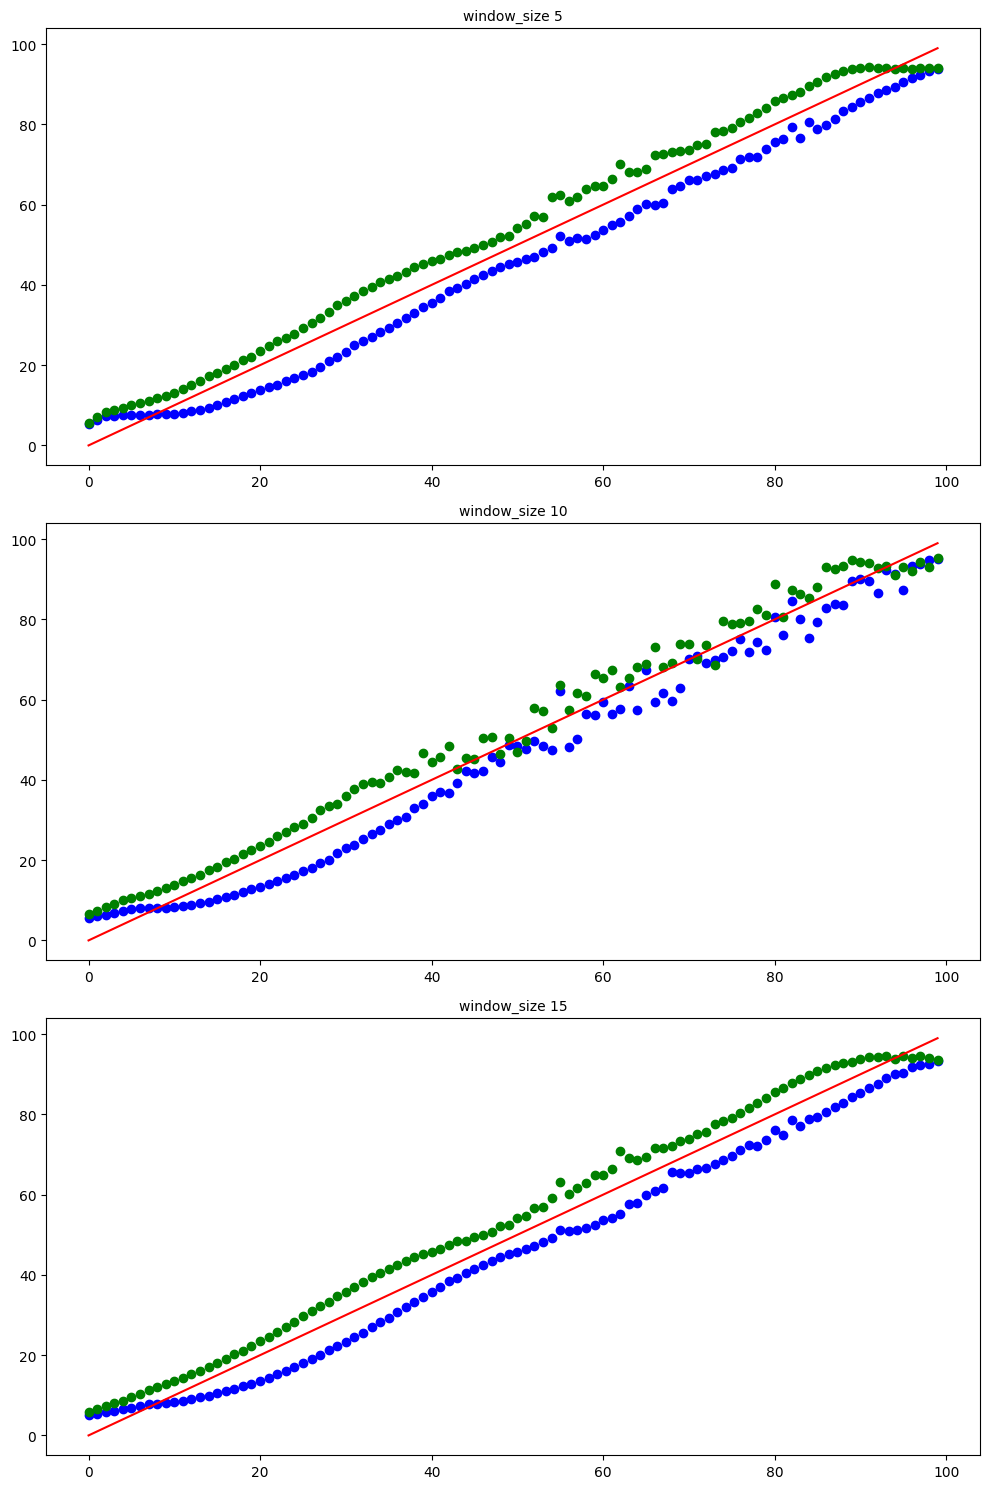

In [10]:
# Plotting the results

# Create subplots (2 rows, 3 columns)
fig, axs = plt.subplots(3, 1, figsize=(10, 15))


for i in forecasts.index:
        
    axs[int(i/5)-1].scatter(y[:int(len(y)/2)], forecasts.loc[i][:int(forecasts.loc[i].count()/2)], color = 'blue')
    axs[int(i/5)-1].scatter(y[int(len(y)/2):], forecasts.loc[i][int(forecasts.loc[i].count()/2):], color = 'green')
    axs[int(i/5)-1].plot([min(y), max(y)], [min(y), max(y)], color='red')  # Line for perfect prediction
    axs[int(i/5)-1].set_title('window_size ' + str(i), fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


Essa ponderação de window size como ta agora é superficial, precisa testar com outras curvas de treinamento pra fazer sentido (e, naturalmente, com dados reais).

## Testando variação com variável indicadora de subida

In [147]:
window_size = 10
degree = 4
    
X, y = generate_sample_data(data, window_size, seed = 42)
z = []
for i in range(len(data)):
    if (i<3 or len(data)-i < 3):
        z.append(2)
    else:
        prev = data[i-3] + data[i-2] + data[i-1]
        post = data[i-3] + data[i+1] + data[i-1]
        if(post-prev > 0):
            z.append(1)
        elif(post-prev == 0):
            z.append(0)
        else:
            z.append(-1)

X = np.column_stack((X, z))
# Create polynomial features of degree 
X_poly = polynomial_features(X, degree=degree)
X_poly = X_poly + np.random.rand(X_poly.shape[0], X_poly.shape[1])/1000000
# Add a bias (intercept) term
X_poly_biased = np.c_[np.ones(X_poly.shape[0]), X_poly]  # Add a column of ones for the bias term

# Calculate the coefficients using the normal equation
theta = np.linalg.solve(X_poly_biased.T @ X_poly_biased, X_poly_biased.T @ y)
#theta = np.linalg.inv(X_poly_biased.T @ X_poly_biased) @ X_poly_biased.T @ y


# Making predictions
predictions = X_poly_biased @ theta

#features.loc[degree] = np.concatenate((theta, np.zeros(25-len(theta))))



/tmp/ipykernel_12865/761050036.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


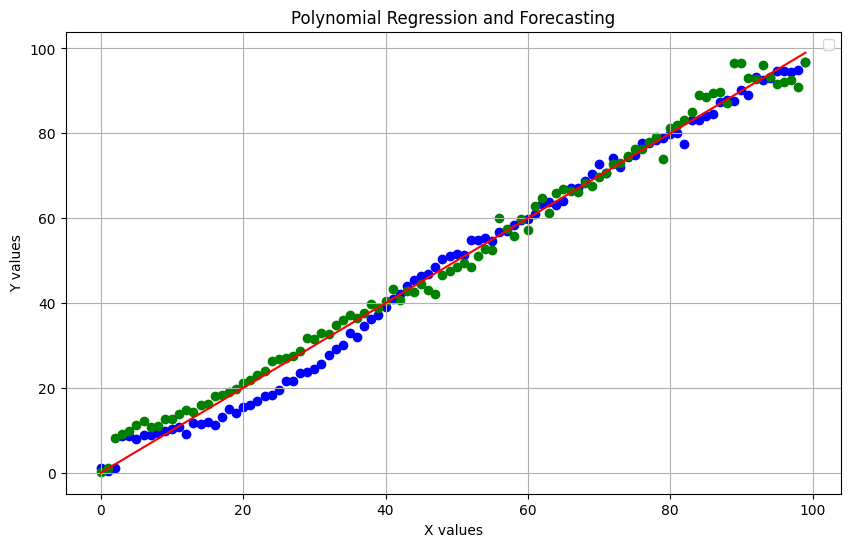

In [148]:
plt.figure(figsize=(10, 6))

plt.scatter(y[:int(len(y)/2)], predictions[:int(len(predictions)/2)], color = 'blue')
plt.scatter(y[int(len(y)/2):], predictions[int(len(predictions)/2):], color = 'green')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  # Line for perfect prediction
plt.title('Grau ' + str(i), fontsize=10)

    
# Add labels and title
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Polynomial Regression and Forecasting')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('polinomial_fake.png')

## Testando generalização dos modelos

Fazer isso quando tiver dados de verdade

## Regresssão com ML

### dados fake

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


/home/oestefal/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [29]:
# tratando dados

X, y = generate_sample_data(data, window_size, seed = 42)

data = 1/(1 + simulated_data_Delta)
indexes = np.array(range(len(data)))
window_size = 10

X = []

for i in range(window_size, len(data)-window_size):
    I = data[i-window_size : i]
    X.append(I)

X = np.array(X)
y = y[window_size:-window_size]

NameError: name 'data' is not defined

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
# Initialize the MLPRegressor with warm_start=True for incremental training
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1, warm_start=True, random_state=42)


In [30]:
n_iterations = 10000  # Number of training iterations
train_errors = []
val_errors = []

for _ in range(n_iterations):
    # Incrementally fit the model
    mlp.partial_fit(X_train, y_train)

    # Predict on the training and test sets
    y_train_pred = mlp.predict(X_train)
    y_val_pred = mlp.predict(X_val)

    # Compute Mean Squared Error
    train_error = mean_squared_error(y_train, y_train_pred)
    val_error = mean_squared_error(y_val, y_val_pred)

    # Store errors
    train_errors.append(train_error)
    val_errors.append(val_error)


NameError: name 'mlp' is not defined

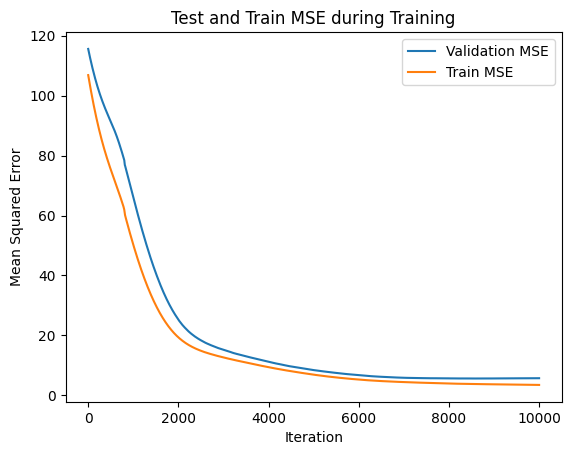

In [62]:
# Plot test and train error (Mean Squared Error)
plt.plot(val_errors, label='Validation MSE')
plt.plot(train_errors, label='Train MSE')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Test and Train MSE during Training')
plt.legend()
plt.show()


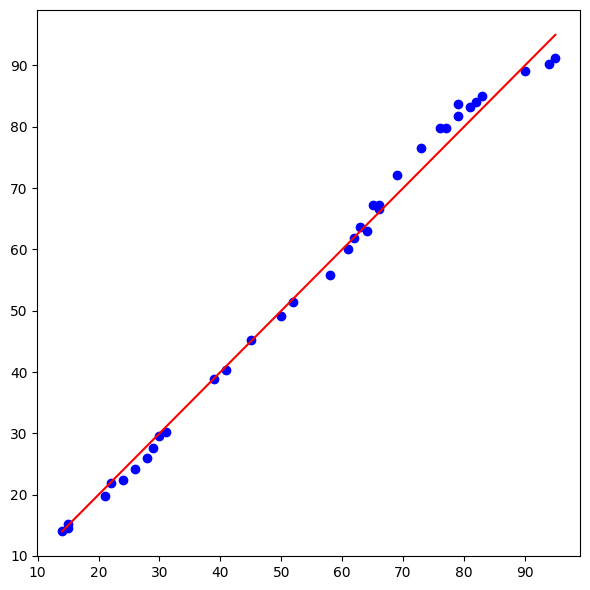

In [74]:
y_test_pred = mlp.predict(X_test)

# Create subplots (2 rows, 3 columns)
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

plt.scatter(y_test, y_test_pred, color = 'blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line for perfect prediction

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


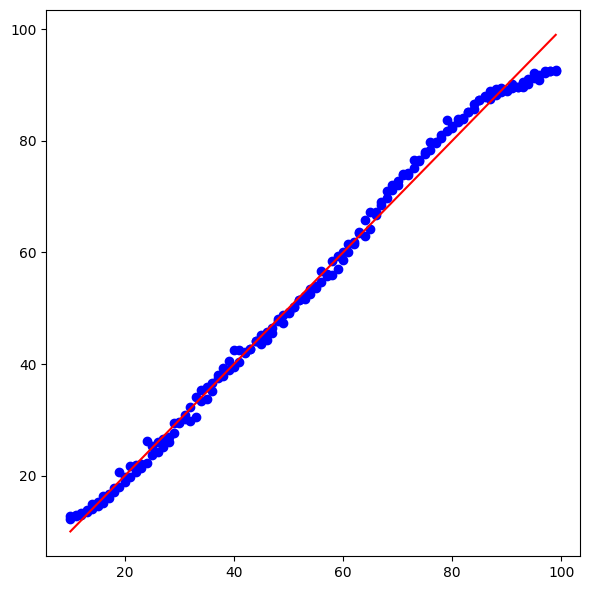

In [75]:
y_pred = mlp.predict(X)

# Create subplots (2 rows, 3 columns)
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

plt.scatter(y, y_pred, color = 'blue')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  # Line for perfect prediction

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


## Dados de verdade

### EE

#### Sem componente de sinal da integral

In [23]:
from tqdm import tqdm
# tratando dados
df = pd.read_csv("raw_data_02_manual")

features = df["FSR"].to_numpy()
y = df["LoadCell"].to_numpy()

window_size = 10
X, _ = generate_sample_data(features, window_size, seed = 42)



degree = 4

# Create polynomial features of degree 
X_poly = polynomial_features(X, degree=degree)
# Add a bias (intercept) term
X_poly_biased = np.c_[np.ones(X_poly.shape[0]), X_poly]  # Add a column of ones for the bias term

# Calculate the coefficients using the normal equation
theta = np.linalg.inv(X_poly_biased.T @ X_poly_biased) @ X_poly_biased.T @ y

# Making predictions
predictions = X_poly_biased @ theta

    

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

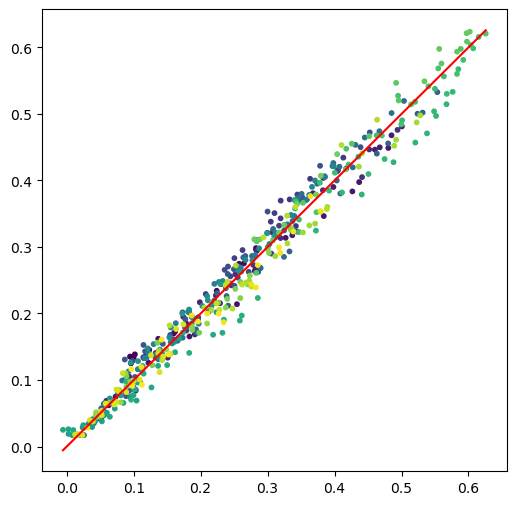

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(predictions)))  # Use a colormap like 'viridis'

plt.scatter(y/1000, predictions/1000, c=colors, s=10)
plt.plot([min(y/1000), max(y/1000)], [min(y/1000), max(y/1000)], color='red')  # Line for perfect prediction
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='Index Gradient')  # Add a colorbar for reference
# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('polinomial_real.png')

#### Com componente de sinal da integral

In [12]:
from tqdm import tqdm
# tratando dados
df = pd.read_csv("raw_data_01")

features = df["FSR"].to_numpy()
y = df["LoadCell"].to_numpy()

window_size = 10
X, _ = generate_sample_data(features, window_size, seed = 42)
z = []
for i in range(len(features)):
    if (i<3 or len(features)-i < 3):
        z.append(0.01)
    else:
        prev = features[i-3] + features[i-2] + features[i-1]
        post = features[i-3] + features[i+1] + features[i-1]
        if(post-prev > 0):
            z.append(1)
        elif(post-prev == 0):
            z.append(0)
        else:
            z.append(-1)

#X = np.column_stack((X, z))

degree = 4

# Create polynomial features of degree 
X_poly = polynomial_features(X, degree=degree)
#X_poly = X_poly + np.random.rand(X_poly.shape[0], X_poly.shape[1])/1000000
# Add a bias (intercept) term
X_poly_biased = np.c_[np.ones(X_poly.shape[0]), X_poly]  # Add a column of ones for the bias term
X_poly_biased = np.column_stack((X_poly_biased, z))
# Calculate the coefficients using the normal equation
theta = np.linalg.inv(X_poly_biased.T @ X_poly_biased) @ X_poly_biased.T @ y

# Making predictions
predictions = X_poly_biased @ theta

    

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

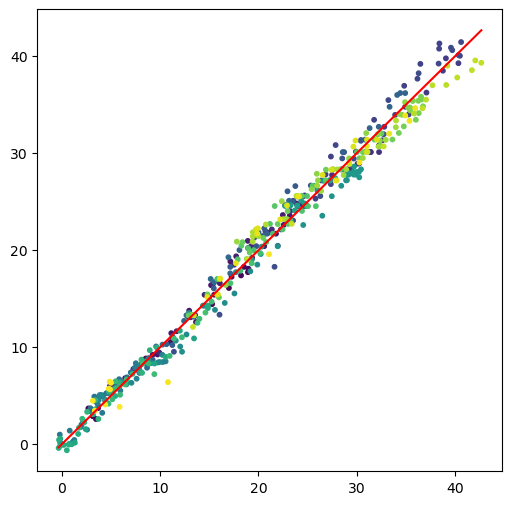

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(predictions)))  # Use a colormap like 'viridis'


plt.scatter(y/1000, predictions/1000, c=colors, s=10)
plt.plot([min(y/1000), max(y/1000)], [min(y/1000), max(y/1000)], color='red')  # Line for perfect prediction
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='Index Gradient')  # Add a colorbar for reference
# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


No fim das contas nem chegou a ser muito útil pra dados reais. Bom colocar isso no relatório.

### NN

In [208]:
data = df["FSR"].to_numpy()
y = df["LoadCell"].to_numpy()

X = []
window_size = 30
for i in range(window_size, len(data)-window_size):
    I = data[i-window_size : i]
    X.append(I)

X = np.array(X)
y = y[window_size:-window_size]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#### Modelo por scikitlearn

In [167]:
from tqdm import tqdm
# tratando dados
df = pd.read_csv("raw_data_01")

# Initialize the MLPRegressor with warm_start=True for incremental training
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1, warm_start=True, random_state=42)

n_iterations = 100000  # Number of training iterations

train_errors = []
val_errors = []

for _ in tqdm(range(n_iterations)):
    # Incrementally fit the model
    mlp.partial_fit(X_train, y_train)

    # Predict on the training and test sets
    y_train_pred = mlp.predict(X_train)
    y_val_pred = mlp.predict(X_val)

    # Compute Mean Squared Error
    train_error = mean_squared_error(y_train, y_train_pred)
    val_error = mean_squared_error(y_val, y_val_pred)

    # Store errors
    train_errors.append(train_error)
    val_errors.append(val_error)


  1%|▎                                    | 724/100000 [00:04<11:09, 148.29it/s]


KeyboardInterrupt: 

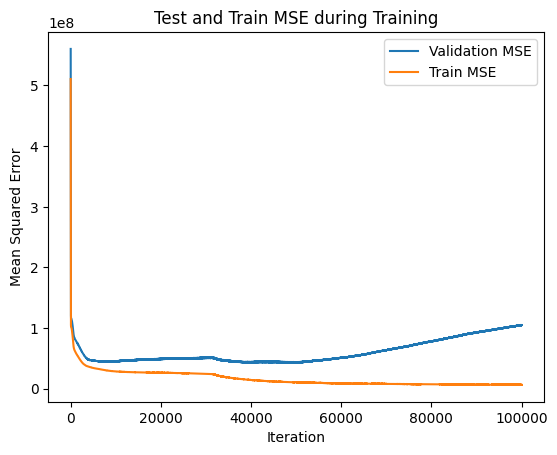

In [88]:
# Plot test and train error (Mean Squared Error)
plt.plot(val_errors, label='Validation MSE')
plt.plot(train_errors, label='Train MSE')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Test and Train MSE during Training')
plt.legend()
plt.show()


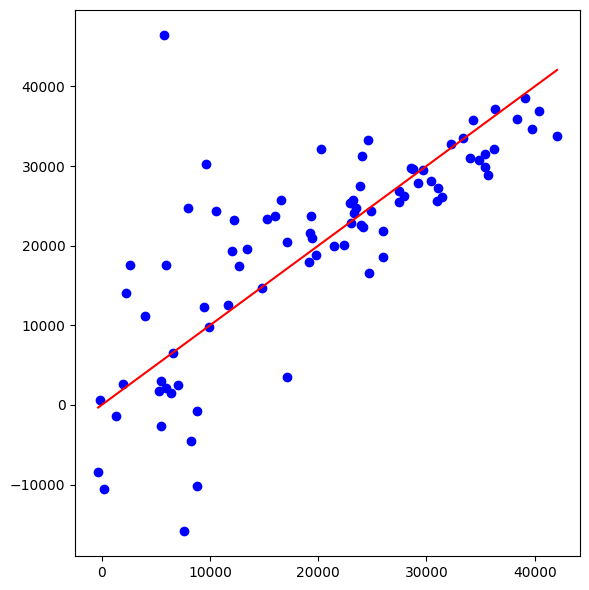

In [110]:
y_test_pred = mlp.predict(X_test)

# Create subplots (2 rows, 3 columns)
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

plt.scatter(y_test, y_test_pred, color = 'blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line for perfect prediction

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [162]:
y_pred = mlp.predict(X)

# Create subplots (2 rows, 3 columns)
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

plt.scatter(y, y_pred, color = 'blue')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  # Line for perfect prediction

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


NameError: name 'mlp' is not defined

#### Definindo FNN com pytorch e fazendo teste

In [191]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

In [209]:
# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

In [193]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Créditos para https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_feedforward_neuralnetwork/#step-2-make-dataset-iterable

In [194]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [195]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.sigmoid = nn.Sigmoid()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)
        # Non-linearity  # NON-LINEAR
        out = self.sigmoid(out)
        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        return out

def early_stopping(train_loss, validation_loss, min_delta, tolerance):

    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
            return True


In [196]:
input_dim = X_train.shape[1]
hidden_dim = 100
output_dim = 1

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [198]:
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  


In [199]:
print(model.parameters())

print(len(list(model.parameters())))

# FC 1 Parameters 
print(list(model.parameters())[0].size())

# FC 1 Bias Parameters
print(list(model.parameters())[1].size())

# FC 2 Parameters
print(list(model.parameters())[2].size())

# FC 2 Bias Parameters
print(list(model.parameters())[3].size())

<generator object Module.parameters at 0x78e367ca2a40>
4
torch.Size([100, 30])
torch.Size([100])
torch.Size([1, 100])
torch.Size([1])


In [221]:
for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    
    # Compute loss
    loss = criterion(outputs, y_train)
    
    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
# implementar early stopping


Epoch [10/100], Loss: 122246016.0000
Epoch [20/100], Loss: 122239336.0000
Epoch [30/100], Loss: 122232664.0000
Epoch [40/100], Loss: 122225984.0000
Epoch [50/100], Loss: 122219296.0000
Epoch [60/100], Loss: 122212616.0000
Epoch [70/100], Loss: 122205944.0000
Epoch [80/100], Loss: 122199328.0000
Epoch [90/100], Loss: 122192768.0000
Epoch [100/100], Loss: 122186248.0000


In [ ]:
# colocar tudo dentro de um run pra conseguir iterar
def run(lr, batch_size, epochs #colocar sets aqui):

    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    #configurar dataloaders devidamente
        
    # Creating 
    test_set, validation_set = train_test_split(temporary_set, test_size=0.5, random_state=42)    
    
    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True,
        num_workers=2
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=True,
        num_workers=2
    )
    validation_loader = DataLoader(
        validation_set, batch_size=batch_size, shuffle=True,
        num_workers=2
    )
    
    classes = (
        'plane', 'car', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    )

    # --- 

    cnn = CNN(kernel_size).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = torch.optim.Adam(cnn.parameters())

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        aux = 0
        for data in train_loader:
                
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer_cnn.zero_grad()

            # forward + backward + optimize
            outputs = cnn(inputs)
            loss = -criterion(outputs, labels)
            loss.backward()
            optimizer_cnn.step()
            
            aux += 1
            
    print('Finished Training of - ' + 'lr = ' + str(lr) + ', ' + 'batch_size = ' + str(batch_size) + ', ' + 'kernel_size = ' + str(kernel_size) + ', ' + 'epochs = ' + str(epochs))
    return cnn.evaluate_loss(validation_loader)

In [ ]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

# Load the model for inference
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set the model to evaluation mode

In [ ]:
# Searching best hyperparameter

columns = ["lr", "batch_size", "epochs", "kernel_size", "validation_error"]

table = pd.DataFrame(data=None, index=None, columns=columns, dtype=None, copy=None)

for batch_size in [1024, 2048, 4096]:
    for lr in [0.001, 0.002]:
        for epochs in [1, 2, 5, 10]:
            for kernel_size in [1, 3, 5]:
                validation_error = run(lr, batch_size, epochs, kernel_size)
                table.loc[len(table.index)] = [lr, batch_size, epochs, kernel_size, validation_error]
                


In [ ]:
table

In [ ]:
# Finding minimum error

print(table[table.validation_error == table.validation_error.min()])

#### Usando keras

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Function to create and compile the model
def create_model(input_dim, hidden_layers, hidden_units, learning_rate):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=input_dim, activation='relu'))
    for _ in range(hidden_layers - 1):
        model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model


2024-12-07 02:26:02.633830: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 02:26:02.779065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### buscando hiperparametros com keras

In [1]:
def parameter_search(X, y, parameter_grid):
    results = []
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    for hidden_layers in parameter_grid['hidden_layers']:
        for hidden_units in parameter_grid['hidden_units']:
            for learning_rate in parameter_grid['learning_rate']:
                # Create and train the model with early stopping
                model = create_model(X_train.shape[1], hidden_layers, hidden_units, learning_rate)
                model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          epochs=100, 
                          batch_size=32, 
                          verbose=0, 
                          callbacks=[early_stopping])
                
                # Evaluate on validation set
                val_loss = model.evaluate(X_val, y_val, verbose=0)
                
                # Store the results
                results.append({
                    'hidden_layers': hidden_layers,
                    'hidden_units': hidden_units,
                    'learning_rate': learning_rate,
                    'val_loss': val_loss
                })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    return results_df

# plotting

def plot_losses(data, labels=None, xlabel='X-axis', ylabel='Y-axis', title='Losses'):
    """
    Plot a list of lists as line plots.

    Parameters:
        data (list of lists): List of lists to be plotted.
        labels (list, optional): List of labels for each line plot. If provided, must have the same length as data.
        xlabel (str, optional): Label for the x-axis.
        ylabel (str, optional): Label for the y-axis.
        title (str, optional): Title for the plot.
    """
    # Set the size of the plot
    plt.figure(figsize=(8, 6))

    # Plot each sublist in data
    for i, sublist in enumerate(data):
        if labels:
            label = str(2**labels[i])+' batch_size' if i < len(labels) else None
        else:
            label = None
        plt.plot(sublist, label=label)

    # Add labels and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if labels:
        plt.legend()

    # Show the plot
    plt.show()
    
plot_losses([train_error, test_error])


NameError: name 'train_error' is not defined

In [2]:
if __name__ == "__main__":
    # Generate some sample data
    X = np.random.rand(1000, 10)  # 1000 samples, 10 features
    y = np.random.rand(1000)      # 1000 target values

    # Define the parameter grid
    parameter_grid = {
        'hidden_layers': [1, 2],
        'hidden_units': [16, 32],
        'learning_rate': [0.001, 0.01, 0.1]
    }

    # Perform the parameter search
    results_df = parameter_search(X, y, parameter_grid)
    print(results_df)

NameError: name 'np' is not defined

## Verificando hipotese de movimento browniano

### Dados fake

In [15]:
# picotando dados

# tratando dados
df = pd.read_csv("simulated_data_01")

features = df["FSR"].to_numpy()
y = df["LoadCell"].to_numpy()
window_size = 10

X = []
window_size = 30
for i in range(window_size, len(features)-window_size):
    I = features[i-window_size : i]
    X.append(I)

X = np.flip(np.array(X))

In [16]:
#centralizando dados e verificando histogramas

for i in range(X.shape[0]):
    X[i] = X[i] - X[i][0]
df = pd.DataFrame(X)

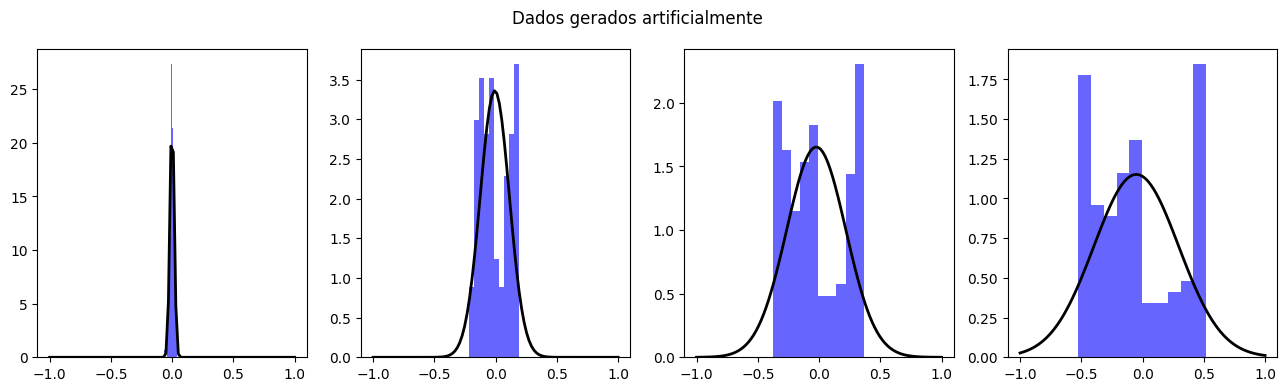

In [153]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16,4))
 
fig.suptitle('Dados gerados artificialmente')

for i in [1, 9, 19, 29]:
    
    j = 0
    match i:
        case 1:
            j = 0

        case 9:
            j = 1

        case 19:
            j = 2

        case 29:
            j = 3
    
    data = df[i]

    mu, std = norm.fit(data) 

    # Plot the histogram.
    axs[j].hist(data, bins=10, density=True, alpha=0.6, color='b')

    # Plot the PDF.
    #xmin, xmax = plt.xlim()
    xmin, xmax = (-1, 1)
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    axs[j].plot(x, p, 'k', linewidth=2)

plt.savefig('ruido_normal_fake.png')

### dados coletados com as mãos

In [25]:
# picotando dados

# tratando dados
df = pd.read_csv("raw_data_02_manual")

features = df["FSR"].to_numpy()
y = df["LoadCell"].to_numpy()
window_size = 10

X = []
window_size = 30
for i in range(window_size, len(features)-window_size):
    I = features[i-window_size : i]
    X.append(I)

X = np.flip(np.array(X))

In [26]:
#centralizando dados e verificando histogramas

for i in range(X.shape[0]):
    X[i] = X[i] - X[i][0]
df = pd.DataFrame(X)

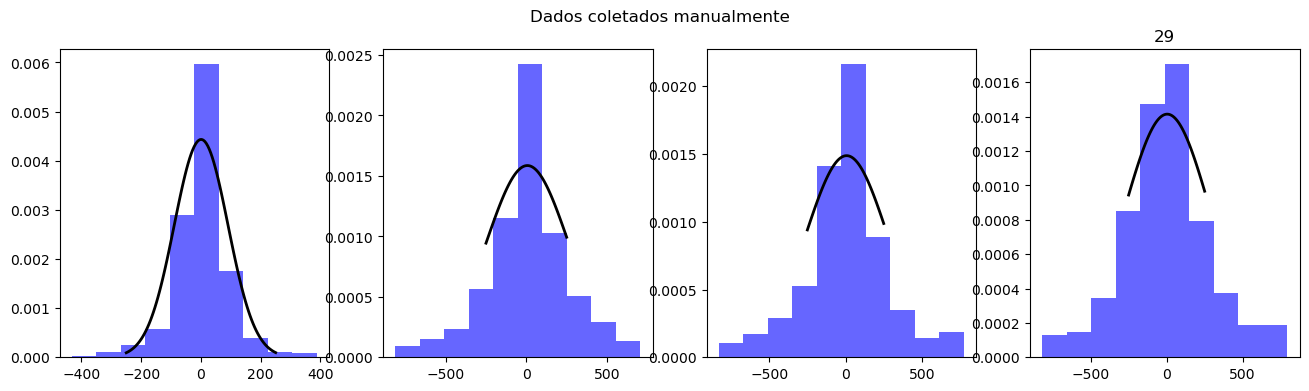

In [28]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16,4))
 
fig.suptitle('Dados coletados manualmente')

for i in [1, 9, 19, 29]:
    
    j = 0
    match i:
        case 1:
            j = 0

        case 9:
            j = 1

        case 19:
            j = 2

        case 29:
            j = 3
    
    data = df[i]

    mu, std = norm.fit(data) 

    # Plot the histogram.
    axs[j].hist(data, bins=10, density=True, alpha=0.6, color='b')

    # Plot the PDF.
    #xmin, xmax = plt.xlim()
    xmin, xmax = (-250, 250)
    
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    axs[j].plot(x, p, 'k', linewidth=2)
    plt.title(i)

plt.savefig('ruido_normal.png')

### Dados coletados com motor

In [31]:
# picotando dados

# tratando dados
df = pd.read_csv("raw_data_02_motor")

features = df["FSR"].to_numpy()
y = df["LoadCell"].to_numpy()
window_size = 10

X = []
window_size = 30
for i in range(window_size, len(features)-window_size):
    I = features[i-window_size : i]
    X.append(I)

X = np.flip(np.array(X))

In [32]:
#centralizando dados e verificando histogramas

for i in range(X.shape[0]):
    X[i] = X[i] - X[i][0]
df = pd.DataFrame(X)

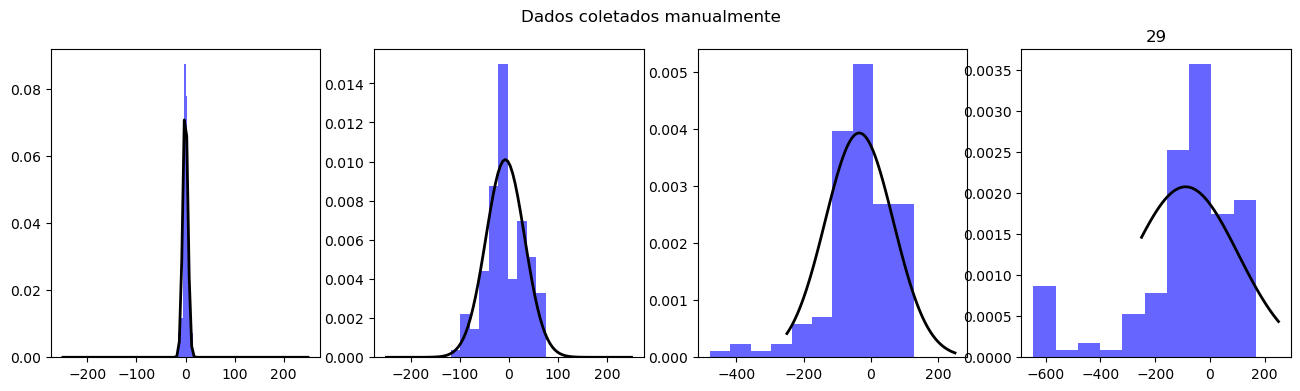

In [33]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16,4))
 
fig.suptitle('Dados coletados manualmente')

for i in [1, 9, 19, 29]:
    
    j = 0
    match i:
        case 1:
            j = 0

        case 9:
            j = 1

        case 19:
            j = 2

        case 29:
            j = 3
    
    data = df[i]

    mu, std = norm.fit(data) 

    # Plot the histogram.
    axs[j].hist(data, bins=10, density=True, alpha=0.6, color='b')

    # Plot the PDF.
    #xmin, xmax = plt.xlim()
    xmin, xmax = (-250, 250)
    
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    axs[j].plot(x, p, 'k', linewidth=2)
    plt.title(i)

plt.savefig('ruido_normal.png')